# **GARCH and EGarch Models**

## **0.0 Imports**

In [4]:
import pandas as pd
import yfinance as yf
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

### **0.1 Load Data**

In [5]:
#Get data
ticker = yf.Ticker("USDBRL=X")


#Into df
start = '2006-01-01'
end = '2021-10-01'

df_usd = ticker.history(start=start, end = end, interval = "1d").reset_index()

#Get only close data
cols = ['Date', 'Close']
df_usd = df_usd[cols].set_index('Date')

### **0.2. Helper Function**

In [6]:

##pd.set_option('display.float_format', lambda x: '%.2f' % x)
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [13, 6]
    plt.rcParams['font.size'] = 20
    
    #display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### **0.3 Data Visualization**

Text(0.5, 0, 'Data')

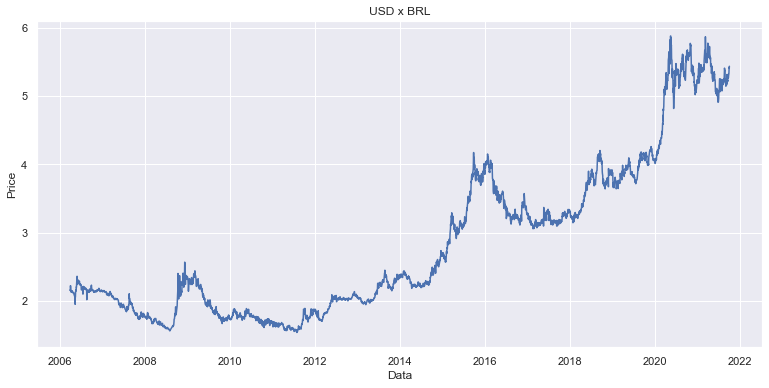

In [7]:
sns.lineplot(x = 'Date', y = 'Close', data = df_usd)
plt.title('USD x BRL')
plt.ylabel('Price')
plt.xlabel('Data')

### **0.4 Check NA**

In [8]:
df_usd.isna().sum()

Close    0
dtype: int64

# **1.0 Non-Normality Distribution of Fat Tails**    

### *The Jacque Bera is a test of whether sample data have the skewness and kurtosis matching a normal distriubtion.*

In [9]:
#Test
jarque_bera = scipy.stats.jarque_bera(df_usd['Close'])

#Test Statistic
jarque_bera.statistic

#P value
jarque_bera.pvalue


0.0

# **2.0 Serial Correlation and Unit Root**

## **2.1 PACF and ACF tests**

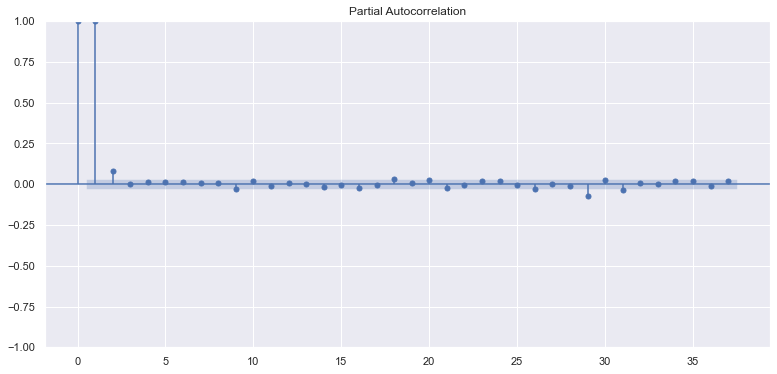

In [10]:
plot_pacf(df_usd['Close'])
plt.show()

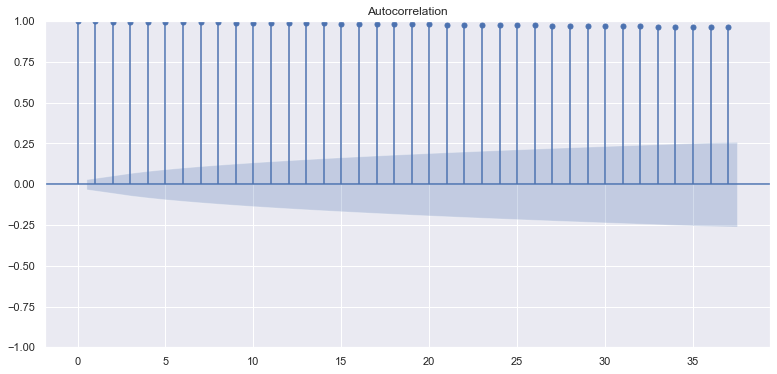

In [11]:
plot_acf(df_usd['Close'])
plt.show()

## **2.1 Stationary Tests**

### **2.1.1 Test without any differences - ADF test > -2.862 (5%): Non-stationary serie**

In [12]:
result = adfuller(df_usd['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.381380
p-value: 0.980785
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.2 Test with one differences - ADF Test < -2.862 (5%). We have a stationary serie**

In [13]:
#Get first diff
df2 = df_usd.copy().diff()

#Dropping NA values
df2.dropna(inplace = True)

In [14]:
result_diff = adfuller(df2['Close'])
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.352266
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


### **2.1.3 Test without any differences - KPSS > 0.463 (5%). Non Stationary serie**

In [15]:
result_kpss = kpss(df_usd['Close'])
print('ADF Statistic: %f' % result_kpss[0])
print('p-value: %f' % result_kpss[1])
print('Critical Values:')
for key, value in result_kpss[3].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 8.197214
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


### **2.1.3 Test with one differences - KPSS <> 0.463 (5%).  Stationary serie**

In [16]:
result_diff_kpss = kpss(df2['Close'])
print('ADF Statistic: %f' % result_diff_kpss[0])
print('p-value: %f' % result_diff_kpss[1])
print('Critical Values:')
for key, value in result_diff_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.291064
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


# **3.0 Modeling**

## **3.1. The GARCH Model**


In [17]:
#Copy dataset 
df3 = df_usd.copy()

#calcuting the daily return over period
df3['return'] = 100*(df3['Close']).pct_change()


## **3.2. Plotting daily return**


Text(0.5, 0, 'Return')

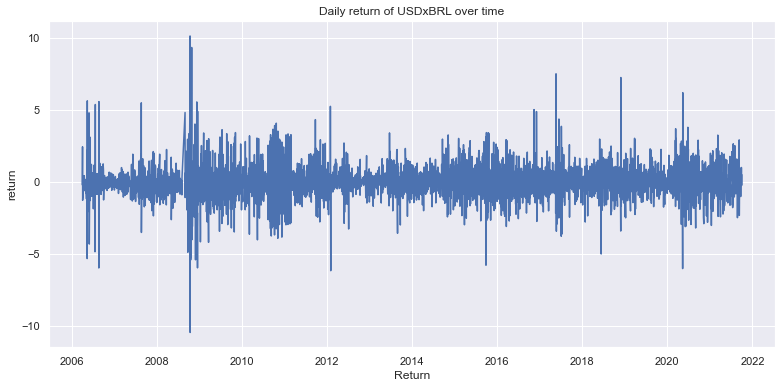

In [18]:
sns.lineplot(x = 'Date', y = 'return', data = df3);
plt.title('Daily return of USDxBRL over time')
plt.xlabel('Return')


## **3.3. Calculation of daily, monthly and annual volatility**


In [19]:
daily_volatility = df3['return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility ))

Daily volatility:  1.20%
Monthly volatility:  5.51%
Annual volatility:  19.07%


## **3.4. Building a GARCH(1,1) model**


In [20]:
df3 = df_usd.copy()

#Return
df3['Return'] = 100*(df3['Close'].pct_change())
df3 = df3.dropna()

In [37]:
test_size = int(len(df3['Return']) * 0.7)

2803

In [38]:
test_size = int(len(df3['Return']) * 0.7)

train,test = df3[:-test_size], df3[-test_size:]

#Build a Garch Model

garch_model = arch_model(df3['Return'] ** 2, p = 1, q=1, mean = 'AR', lags= 2, vol = 'GARCH', dist='normal')

gm_result = garch_model.fit()

gm_result.summary()
#print(gm_result.params)
#
#print('\n')
#
#
##Forecast
#gm_forecast = gm_result.forecast(horizon = 5)
#print(gm_forecast.variance[-1:]);

Iteration:      1,   Func. Count:      8,   Neg. LLF: 39533.80156447665
Iteration:      2,   Func. Count:     20,   Neg. LLF: 21860834.203170978
Iteration:      3,   Func. Count:     30,   Neg. LLF: 118791.38868172579
Iteration:      4,   Func. Count:     40,   Neg. LLF: 3176247.0055591245
Iteration:      5,   Func. Count:     48,   Neg. LLF: 10307.97321982548
Iteration:      6,   Func. Count:     56,   Neg. LLF: 9668.954856609103
Iteration:      7,   Func. Count:     63,   Neg. LLF: 9666.320753664611
Iteration:      8,   Func. Count:     70,   Neg. LLF: 9664.507480975859
Iteration:      9,   Func. Count:     77,   Neg. LLF: 9664.298678654737
Iteration:     10,   Func. Count:     84,   Neg. LLF: 9664.137297567146
Iteration:     11,   Func. Count:     91,   Neg. LLF: 9664.134143352858
Iteration:     12,   Func. Count:     98,   Neg. LLF: 9664.133925477443
Iteration:     13,   Func. Count:    104,   Neg. LLF: 9664.13392252547
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.143
Mean Model:                        AR   Adj. R-squared:                  0.143
Vol Model:                      GARCH   Log-Likelihood:               -9664.13
Distribution:                  Normal   AIC:                           19340.3
Method:            Maximum Likelihood   BIC:                           19378.0
                                        No. Observations:                 4003
Date:                Mon, Oct 04 2021   Df Residuals:                     4000
Time:                        22:13:42   Df Model:                            3
                                 Mean Model                                 
============================================================================
                  coef    std err          t      P>|t|     95.0% Conf. Int.
----------------------------------------------------------------------------
Const           0.6907      0.117      5.904  3.540e-09    [  0.461,  0.920]
Return[1]       0.3018      0.173      1.746  8.081e-02 [-3.698e-02,  0.641]
Return[2]  -8.7619e-03      0.137 -6.373e-02      0.949    [ -0.278,  0.261]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.6725      0.909      1.840  6.570e-02   [ -0.109,  3.454]
alpha[1]       0.4247      0.174      2.440  1.468e-02 [8.356e-02,  0.766]
beta[1]        0.5753      0.135      4.260  2.043e-05   [  0.311,  0.840]
==========================================================================

Covariance estimator: robust
"""

## **3.4.0 Rolling forecast using GARCH model**


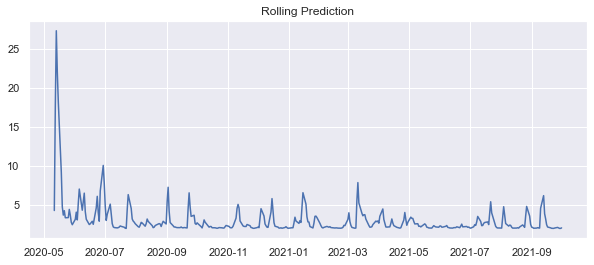

In [50]:
rolling_predictions = []
test_size = 365
retorno = df3['Return'] ** 2

for i in range(test_size):
    train = retorno[:-(test_size-i)]
    model = arch_model(train, p = 2, q=2, mean = 'AR', lags= 2, vol = 'GARCH')
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=5)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_predictions = pd.Series(rolling_predictions, index=df3['Return'].index[-365:])

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

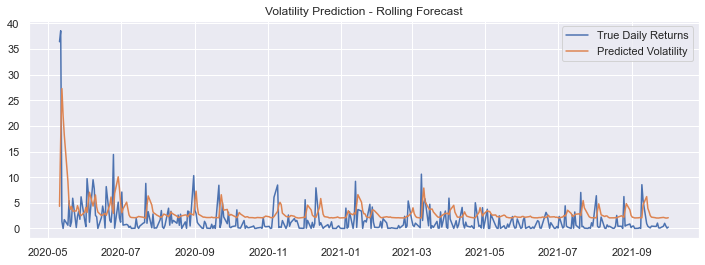

In [51]:
plt.figure(figsize=(12,4))
plt.plot(retorno[-365:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast')
plt.legend(['True Daily Returns', 'Predicted Volatility'])
plt.show()